In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

     | 13.4MB 417kB/s
  Created wheel for Theano: filename=Theano-1.0.4+unknown-cp36-none-any.whl size=2666479 sha256=aded087b82575d263b6547608d5d7c8147ae58cada1f115c5e2325960b7ba3df
  Stored in directory: /tmp/pip-ephem-wheel-cache-xi8tyffu/wheels/33/73/96/0ed263c62a86e2485ea634e0d3ae8169d50fd66e3b252541db
Successfully built Theano
  Found existing installation: Theano 1.0.4+unknown
    Uninstalling Theano-1.0.4+unknown:
      Successfully uninstalled Theano-1.0.4+unknown
     | 235kB 429kB/s
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-cp36-none-any.whl size=122750 sha256=02053441824b35dc6633bf436ce35389bd6caf0f6651c0c8314642b97ab07e02
  Stored in directory: /tmp/pip-ephem-wheel-cache-prsi3psi/wheels/ca/4a/00/87f1777b229481fe76562df7c0cfb993bc88ed0cc37e3f0ed4
Successfully built Lasagne
  Found existing installation: Lasagne 0.2.dev1
    Uninstalling Lasagne-0.2.dev1:
      Successfully uninstalled Lasagne-0.2.dev1


In [4]:
#!git clone https://github.com/jaredleekatzman/DeepSurv.git
!pip install "/content/gdrive/My Drive/Colab Notebooks/DeepSurv/"

Processing ./gdrive/My Drive/Colab Notebooks/DeepSurv
     |████████████████████████████████| 348kB 6.5MB/s 
  Created wheel for deepsurv: filename=deepsurv-0.2.1-cp36-none-any.whl size=18124 sha256=f6580bf3bbfe9d4f615a006c7e295a579e1ea3a208d68cec71235bf8a9c743b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-ekz5ir5k/wheels/eb/37/cc/9355b6063f4eeb3dfea2e56ba73f27f8d4447ed801d7046c30
Successfully built deepsurv


In [2]:
# Use DeepSurv from the repo
%tensorflow_version 2.x
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DeepSurv/deepsurv')
import deepsurv

from deepsurv_logger import DeepSurvLogger, TensorboardLogger
import utils
import viz

import numpy as np
import pandas as pd

import lasagne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


TensorFlow 2.x selected.


# Read in dataset
First, I read in the dataset and print the first five elements to get a sense of what the dataset looks like

In [3]:
train_dataset_fp = '/content/gdrive/My Drive/Colab Notebooks/Survival/example_data.csv'
train_df = pd.read_csv(train_dataset_fp)
train_df.head()

,Variable_1,Variable_2,Variable_3,Variable_4,Event,Time
0,0,3,2,4.6,1,43
1,0,2,0,1.6,0,52
2,0,3,0,3.5,1,73
3,0,3,1,5.1,0,51
4,0,2,0,1.7,0,51


# Transform the dataset to "DeepSurv" format
DeepSurv expects a dataset to be in the form:

    {
        'x': numpy array of float32
        'e': numpy array of int32
        't': numpy array of float32
        'hr': (optional) numpy array of float32
    }
    
You are providing me a csv, which I read in as a pandas dataframe. Then I convert the pandas dataframe into the DeepSurv dataset format above. 

In [0]:
# event_col is the header in the df that represents the 'Event / Status' indicator
# time_col is the header in the df that represents the event time
def dataframe_to_deepsurv_ds(df, event_col = 'Event', time_col = 'Time'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset
train_data = dataframe_to_deepsurv_ds(train_df, event_col = 'Event', time_col= 'Time')

In [5]:
train_data

{'e': array([1, 0, 1, ..., 0, 0, 1], dtype=int32),
 't': array([43., 52., 73., ...,  4., 41., 33.], dtype=float32),
 'x': array([[0. , 3. , 2. , 4.6],
        [0. , 2. , 0. , 1.6],
        [0. , 3. , 0. , 3.5],
        ...,
        [0. , 3. , 0. , 3.1],
        [0. , 2. , 0. , 1.8],
        [0. , 2. , 0. , 2.3]], dtype=float32)}

Now once you have your dataset all formatted, define you hyper_parameters as a Python dictionary. 
I'll provide you with some example hyper-parameters, but you should replace the values once you tune them to your specific dataset

In [0]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
}

Once you prepared your dataset, and defined your hyper-parameters. Now it's time to train DeepSurv!

In [7]:
# Create an instance of DeepSurv using the hyperparams defined above
model = deepsurv.DeepSurv(**hyperparams)

# DeepSurv can now leverage TensorBoard to monitor training and validation
# This section of code is optional. If you don't want to use the tensorboard loggerl
# Uncomment the below line, and comment out the other three lines: 
# logger = None

experiment_name = 'test_experiment_sebastian'
logdir = './logs/tensorboard/'
logger = TensorboardLogger(experiment_name, logdir=logdir)

# Now we train the model
update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                            # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                            # for other optimizers to use
n_epochs = 2000

# If you have validation data, you can add it as the second parameter to the function
metrics = model.train(train_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


2019-10-28 21:07:33,040 - Training step 0/2000    |                         | - loss: 26.2822 - ci: 0.5561
2019-10-28 21:08:14,171 - Training step 250/2000  |***                      | - loss: 13.2729 - ci: 0.6174
2019-10-28 21:08:55,128 - Training step 500/2000  |******                   | - loss: 8.6649 - ci: 0.6290
2019-10-28 21:09:37,084 - Training step 750/2000  |*********                | - loss: 7.0427 - ci: 0.6461
2019-10-28 21:10:17,957 - Training step 1000/2000 |************             | - loss: 6.4640 - ci: 0.6698
2019-10-28 21:10:59,503 - Training step 1250/2000 |***************          | - loss: 6.2812 - ci: 0.6946
2019-10-28 21:11:41,336 - Training step 1500/2000 |******************       | - loss: 6.2082 - ci: 0.7019
2019-10-28 21:12:23,453 - Training step 1750/2000 |*********************    | - loss: 6.1796 - ci: 0.7053
2019-10-28 21:13:04,426 - Finished Training with 2000 iterations in 332.50s


# New Section

There are two different ways to visualzie how the model trained:

- Tensorboard (install ()[tensorboard]) which provides realtime metrics. Run the command in shell:
   
   `tensorboard --logdir './logs/tensorboard'`
     
     
- Visualize the training functions post training (below)

Train C-Index: (1999, 0.7055496548061604)


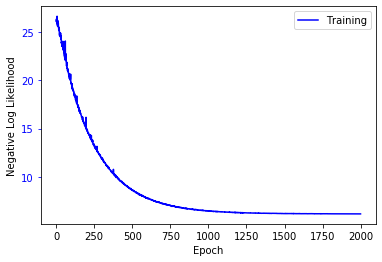

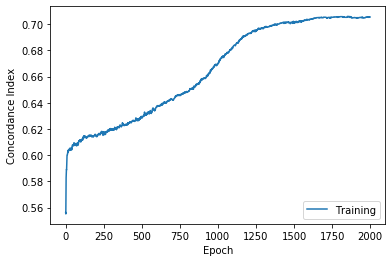

In [8]:
# Print the final metrics
print('Train C-Index:', metrics['c-index'][-1])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

# Plot the training / validation curves
viz.plot_log(metrics)

In [0]:
model.pr